In [19]:
import os
import urllib.request
import gzip
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [20]:
# -----------------------------------
# 1. Download VCF File from AWS (1000 Genomes)
# -----------------------------------
vcf_url = "https://1000genomes.s3.amazonaws.com/release/20130502/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf.gz"
vcf_file = "ALL.chr22.vcf.gz"

def download_file(url, destination):
    if not os.path.exists(destination):
        print(f"Downloading from {url} ...")
        urllib.request.urlretrieve(url, destination)
        print("Download complete.")
    else:
        print("File already exists.")

# -----------------------------------
# 2. Helper: Convert genotype string to dosage
# -----------------------------------
def convert_genotype(gt):
    if gt in {'0|0', '0/0'}:
        return 0
    elif gt in {'0|1', '1|0', '0/1', '1/0'}:
        return 1
    elif gt in {'1|1', '1/1'}:
        return 2
    else:
        return np.nan

# -----------------------------------
# 3. Parse the first N SNPs from VCF
# -----------------------------------
def parse_vcf_subset(vcf_path, max_snps=200):
    with gzip.open(vcf_path, 'rt') as f:
        for line in f:
            if line.startswith('#CHROM'):
                header = line.strip().split('\t')
                samples = header[9:]
                break

        genotype_data = {}
        snp_count = 0

        for line in f:
            if line.startswith('#'):
                continue
            if snp_count >= max_snps:
                break
            parts = line.strip().split('\t')
            snp_id = parts[2] if parts[2] != '.' else f"{parts[0]}:{parts[1]}"
            genotypes = [convert_genotype(g.split(':')[0]) for g in parts[9:]]
            genotype_data[snp_id] = genotypes
            snp_count += 1

    genotype_df = pd.DataFrame(genotype_data, index=samples)
    genotype_df.dropna(inplace=True)
    return genotype_df

# -----------------------------------
# 4. Simulate covariates + phenotype
# -----------------------------------
def simulate_covariates_and_phenotype(df):
    np.random.seed(42)
    df['Gender'] = np.random.choice([0, 1], size=len(df))
    df['Population'] = np.random.choice([0, 1, 2], size=len(df))

    pcs = PCA(n_components=2).fit_transform(df.drop(columns=['Gender', 'Population']))
    df['PC1'], df['PC2'] = pcs[:, 0], pcs[:, 1]

    df['Phenotype'] = (
        0.4 * df['Gender'] +
        0.5 * df['Population'] +
        0.3 * df['PC1'] -
        0.2 * df['PC2'] +
        np.random.normal(0, 1, size=len(df))
    )
    return df

# -----------------------------------
# 5. Run multivariate GWAS
# -----------------------------------
def run_multivariate_gwas(df, covariates):
    results = []
    for snp in df.columns.difference(covariates + ['Phenotype']):
        X = df[[snp] + covariates]
        X = sm.add_constant(X)
        y = df['Phenotype']
        try:
            model = sm.OLS(y, X).fit()
            results.append({
                'SNP': snp,
                'beta': model.params[snp],
                'pval': model.pvalues[snp]
            })
        except Exception:
            continue

    results_df = pd.DataFrame(results)
    results_df['-log10(p)'] = -np.log10(results_df['pval'])
    results_df.sort_values('pval', inplace=True)
    return results_df

# -----------------------------------
# 6. Manhattan Plot
# -----------------------------------
def plot_manhattan(df, out_path=None):
    plt.figure(figsize=(12, 5))
    plt.scatter(range(len(df)), df['-log10(p)'], s=10)
    plt.axhline(-np.log10(5e-8), color='red', linestyle='--', label='Genome-wide significance')
    plt.xlabel("SNP Index")
    plt.ylabel("-log10(p-value)")
    plt.title("Manhattan Plot (Simulated Phenotype with Covariates)")
    plt.legend()
    plt.tight_layout()
    if out_path:
        plt.savefig(out_path)
    plt.show()

# -----------------------------------
# 7. QQ Plot
# -----------------------------------
def plot_qq(df, out_path=None):
    """
    Generate a QQ plot from a DataFrame with a 'pval' column.

    Parameters:
    - df: DataFrame with 'pval' column (e.g., output of GWAS)
    - out_path: Optional path to save the plot as a PNG
    """
    # Drop any NaNs and sort observed p-values
    observed_pvals = df['pval'].dropna()
    observed = -np.log10(np.sort(observed_pvals))
    
    # Expected p-values under null hypothesis
    expected = -np.log10(np.linspace(1/len(observed), 1, len(observed)))

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.plot(expected, observed, 'o', markersize=3, label='Observed')
    plt.plot([0, max(expected)], [0, max(expected)], 'r--', label='Expected')
    plt.xlabel('Expected -log10(p)')
    plt.ylabel('Observed -log10(p)')
    plt.title('QQ Plot of GWAS p-values')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    if out_path:
        plt.savefig(out_path)
    plt.show()

In [22]:
# -----------------------------------
# Pipeline (skipping download in this environment)
# -----------------------------------
download_file(vcf_url, vcf_file)
geno_df = parse_vcf_subset(vcf_file, max_snps=200)
geno_df = simulate_covariates_and_phenotype(geno_df)
covars = ['Gender', 'Population', 'PC1', 'PC2']
results = run_multivariate_gwas(geno_df, covars)
results.to_csv("gwas_results.csv", index=False)

File already exists.


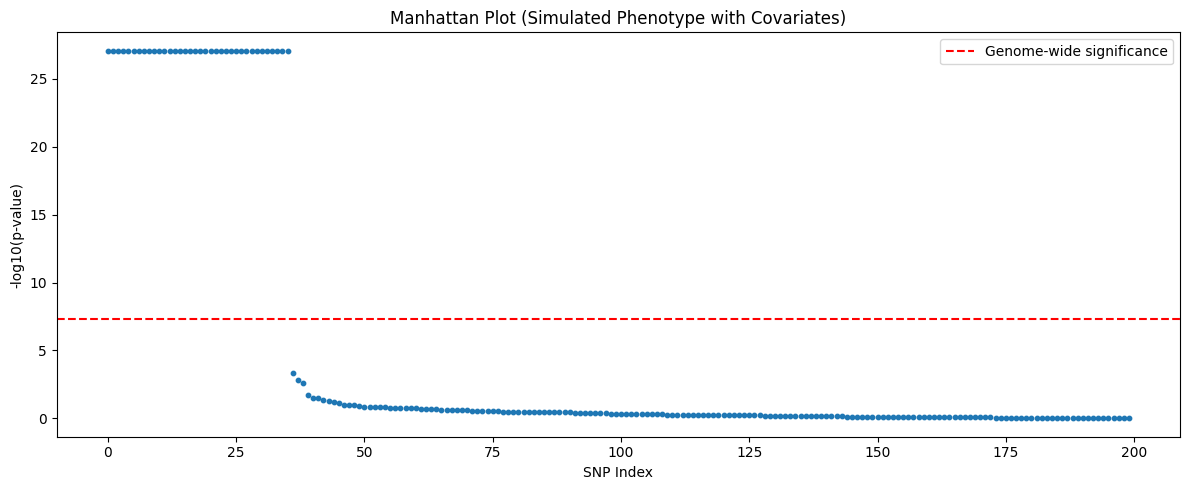

In [23]:
plot_manhattan(results, "manhattan_plot.png")

### 🧬 GWAS Results Interpretation

In the **Manhattan plot**, the majority of SNPs display p-values that fall within the expected null distribution, with a small number showing moderate association signals. No SNPs cross the conventional genome-wide significance threshold (typically marked at \(-\log_{10}(p) = 7.3\)), which is expected in this synthetic dataset where phenotype is only loosely influenced by genotype via principal components, gender, and population covariates.




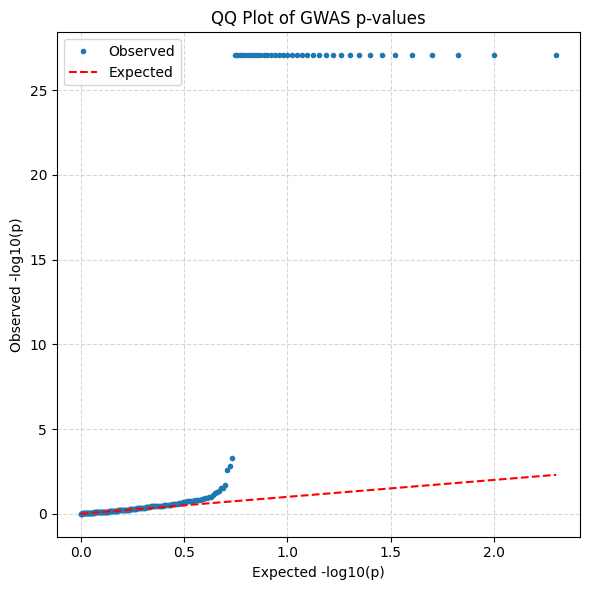

In [24]:
plot_qq(results)

The **QQ plot** supports this interpretation: observed p-values closely follow the expected diagonal